In [1]:
import numpy as np
import pandas as pd
import re
import itertools

### Functions

In [2]:
def clear_references(df):
    for column in df:
        df[column] = df[column].map(lambda x: re.sub(r" \[[0-9]*\]$|^nan$",'', str(x)))

In [3]:
def clean_numeric_values(df, column):
    df[column] = df[column].map(lambda x: re.sub(r"^\<|^\>", '', x))
    df = df.replace(
        r'^\s?\.\.\.\s?$|^nan&|Estimates were not available at the time of publication.|Children estimates were not available at the time of publication.', 
        np.nan, regex=True
    )
    df[column] = pd.to_numeric(df[column], downcast="float")
    df = df[['Country', column]]
    return df

In [4]:
def melt_values(df, column):
    df = df.melt(var_name=column, value_name='Country')
    df = df.reindex(columns=['Country', column])
    return df[df['Country'] != ''].reset_index(drop=True)

In [5]:
def merge_duplicate_columns(df):
    for column in df.iloc[:,::2]:
        se1 = df[column]
        se2 = df[column + '.1']
        se = se1.append(se2)
        se = se[se != ''].drop_duplicates().sort_values().reset_index(drop=True)
        df[column] = se
        df.drop(column + '.1', axis=1, inplace=True)
    return df.fillna('')

In [6]:
def boolenize_multiple_values(df):
    lst = []

    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            item = df.iloc[i, j]
            if item not in lst and item != '':
                lst.append(item)

    lst.sort()
    df1 = pd.DataFrame()
    df1["Country"] = pd.Series(lst)

    for column in df.columns:
        column_list = []
        for country in df1["Country"]:
            if country in df[column].values:
                column_list.append('Yes')
            else:
                column_list.append('No')
        df1[column] = pd.Series(column_list)
    return df1

In [7]:
def booleanize_mean_values(df, column, operation):
    if operation == 'higher':
        df.loc[:,column + " is higher than mean"] = df[column].map(lambda x: 1 if x > df[column].mean() else 0)
    elif operation == 'lower':
        df.loc[:,column + " is lower than mean"] = df[column].map(lambda x: 1 if x < df[column].mean() else 0)
    return df

### criminalization_cross_dressing

In [8]:
criminalization_cross_dressing = pd.read_csv('criminalization-cross-dressing.csv', sep=',', skipinitialspace=True)
criminalization_cross_dressing.drop('No data available', axis=1, inplace=True)
criminalization_cross_dressing.head(2)

,Yes only under certain circumstances,Yes only in parts of the country,Yes,No
0,Egypt [1],Argentina [1],Burundi [2],Afghanistan [1]
1,El Salvador [1],NaN,Libya [1],Albania [1]


In [9]:
clear_references(criminalization_cross_dressing)
criminalization_cross_dressing.head(2)

,Yes only under certain circumstances,Yes only in parts of the country,Yes,No
0,Egypt,Argentina,Burundi,Afghanistan
1,El Salvador,,Libya,Albania


In [10]:
criminalization_cross_dressing = melt_values(criminalization_cross_dressing, 'Is cross dressing criminalized')
criminalization_cross_dressing.replace("Yes only in parts of the country", 'Yes', inplace=True)
criminalization_cross_dressing.replace("Yes only under certain circumstances", 'Yes', inplace=True)
criminalization_cross_dressing

,Country,Is cross dressing criminalized
0,Egypt,Yes
1,El Salvador,Yes
2,Eswatini,Yes
3,Kuwait,Yes
4,Syrian Arab Republic,Yes
...,...,...
128,Vanuatu,No
129,Venezuela (Bolivarian Republic of),No
130,Viet Nam,No
131,Zambia,No


### criminalization_prosecution_transgender

In [11]:
criminalization_prosecution_transgender = pd.read_csv('criminalization-prosecution-transgender.csv', sep=',', skipinitialspace=True)
criminalization_prosecution_transgender.head(4)

,Prosecuted,Criminalized,Both criminalized and prosecuted,Neither criminalized nor prosecuted
0,Niue [2],Liberia [1],Angola [1],Afghanistan [1]
1,Syrian Arab Republic [2],Malawi [1],Burundi [2],Albania [1]
2,NaN,Oman [1],Ethiopia [2],Algeria [2]
3,NaN,Saudi Arabia [1],Kuwait [2],Antigua and Barbuda [1]


In [12]:
clear_references(criminalization_prosecution_transgender)
criminalization_prosecution_transgender.head(4)

,Prosecuted,Criminalized,Both criminalized and prosecuted,Neither criminalized nor prosecuted
0,Niue,Liberia,Angola,Afghanistan
1,Syrian Arab Republic,Malawi,Burundi,Albania
2,,Oman,Ethiopia,Algeria
3,,Saudi Arabia,Kuwait,Antigua and Barbuda


In [13]:
criminalization_prosecution_transgender = melt_values(criminalization_prosecution_transgender, 'Are Transgenders prosecuted or criminalized')
criminalization_prosecution_transgender.replace("Neither criminalized nor prosecuted",  "No", inplace=True)
criminalization_prosecution_transgender.replace("Both criminalized and prosecuted",  "Yes", inplace=True)
criminalization_prosecution_transgender.replace("Criminalized",  "Yes", inplace=True)
criminalization_prosecution_transgender.replace("Prosecuted",  "Yes", inplace=True)
criminalization_prosecution_transgender

,Country,Are Transgenders prosecuted or criminalized
0,Niue,Yes
1,Syrian Arab Republic,Yes
2,Liberia,Yes
3,Malawi,Yes
4,Oman,Yes
...,...,...
130,Uzbekistan,No
131,Vanuatu,No
132,Venezuela (Bolivarian Republic of),No
133,Viet Nam,No


### criminalization_same_sex_sexual_acts

In [14]:
criminalization_same_sex_sexual_acts = pd.read_csv('criminalization-same-sex-sexual-acts.csv', sep=',', skipinitialspace=True)
criminalization_same_sex_sexual_acts.head(3)

,Yes penalty not specified,Yes death penalty,Yes imprisonment (14 years - life),Laws penalizing same-sex sexual acts have been decriminalized or never existed,No specific legislation,Yes imprisonment (up to 14 years)
0,Ethiopia [2],Afghanistan [3],Antigua and Barbuda [7],Albania [2],Argentina [2],Algeria [3]
1,Mauritius [2],Iran (Islamic Republic of) [2],Bangladesh [2],Andorra [3],Bolivia (Plurinational State of) [2],Bhutan [3]
2,Namibia [2],Iraq [4],Barbados [8],Angola [3],Burkina Faso [2],Brunei Darussalam [3]


In [15]:
clear_references(criminalization_same_sex_sexual_acts)
criminalization_same_sex_sexual_acts.head(3)

,Yes penalty not specified,Yes death penalty,Yes imprisonment (14 years - life),Laws penalizing same-sex sexual acts have been decriminalized or never existed,No specific legislation,Yes imprisonment (up to 14 years)
0,Ethiopia,Afghanistan,Antigua and Barbuda,Albania,Argentina,Algeria
1,Mauritius,Iran (Islamic Republic of),Bangladesh,Andorra,Bolivia (Plurinational State of),Bhutan
2,Namibia,Iraq,Barbados,Angola,Burkina Faso,Brunei Darussalam


In [16]:
criminalization_same_sex_sexual_acts = melt_values(criminalization_same_sex_sexual_acts, 'Are same sex sexual acts criminalized')
criminalization_same_sex_sexual_acts.replace("Yes death penalty",  "Yes", inplace=True)
criminalization_same_sex_sexual_acts.replace("Laws penalizing same-sex sexual acts have been decriminalized or never existed",  "No", inplace=True)
criminalization_same_sex_sexual_acts.replace("Yes imprisonment (up to 14 years)",  "Yes", inplace=True)
criminalization_same_sex_sexual_acts.replace("Yes imprisonment (14 years - life)",  "Yes", inplace=True)
criminalization_same_sex_sexual_acts.replace("No specific legislation",  "No", inplace=True)
criminalization_same_sex_sexual_acts.replace("Yes penalty not specified",  "Yes", inplace=True)
criminalization_same_sex_sexual_acts

,Country,Are same sex sexual acts criminalized
0,Ethiopia,Yes
1,Mauritius,Yes
2,Namibia,Yes
3,Papua New Guinea,Yes
4,Saint Lucia,Yes
...,...,...
189,Turkmenistan,Yes
190,Tuvalu,Yes
191,Uzbekistan,Yes
192,Zambia,Yes


### criminalization_sex_work

In [17]:
criminalization_sex_work = pd.read_csv('criminalization-sex-work.csv', sep=',', skipinitialspace=True)
criminalization_sex_work.head(3)

,Selling and buying sexual services is criminalized,Selling sexual services is criminalized,Buying sexual services is criminalized,Partial criminalization of sex work,Ancillary activities associated with selling sexual services are criminalized,Ancillary activities associated with buying sexual services are criminalized,Profiting from organizing and/or managing sexual services is criminalized,Other punitive and/or administrative regulation of sex work,Sex work is not subject to punitive regulations and is not criminalized,Issue is determined/differs at subnational level
0,Afghanistan [6],Afghanistan [2],Afghanistan [2],Bangladesh [6],Afghanistan [2],Afghanistan [2],Afghanistan [2],Afghanistan [2],Argentina [2],Argentina [2]
1,Albania [6],Albania [2],Albania [2],Belize [9],Albania [2],Albania [2],Albania [2],Argentina [6],Azerbaijan [6],El Salvador [2]
2,Bahamas [6],Antigua and Barbuda [6],Algeria [6],Bolivia (Plurinational State of) [6],Argentina [2],Botswana [2],Antigua and Barbuda [24],Armenia [2],Belarus [9],Mexico [2]


In [18]:
clear_references(criminalization_sex_work)
criminalization_sex_work.head(3)

,Selling and buying sexual services is criminalized,Selling sexual services is criminalized,Buying sexual services is criminalized,Partial criminalization of sex work,Ancillary activities associated with selling sexual services are criminalized,Ancillary activities associated with buying sexual services are criminalized,Profiting from organizing and/or managing sexual services is criminalized,Other punitive and/or administrative regulation of sex work,Sex work is not subject to punitive regulations and is not criminalized,Issue is determined/differs at subnational level
0,Afghanistan,Afghanistan,Afghanistan,Bangladesh,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Argentina,Argentina
1,Albania,Albania,Albania,Belize,Albania,Albania,Albania,Argentina,Azerbaijan,El Salvador
2,Bahamas,Antigua and Barbuda,Algeria,Bolivia (Plurinational State of),Argentina,Botswana,Antigua and Barbuda,Armenia,Belarus,Mexico


In [19]:
criminalization_sex_work = boolenize_multiple_values(criminalization_sex_work)
criminalization_sex_work

,Country,Selling and buying sexual services is criminalized,Selling sexual services is criminalized,Buying sexual services is criminalized,Partial criminalization of sex work,Ancillary activities associated with selling sexual services are criminalized,Ancillary activities associated with buying sexual services are criminalized,Profiting from organizing and/or managing sexual services is criminalized,Other punitive and/or administrative regulation of sex work,Sex work is not subject to punitive regulations and is not criminalized,Issue is determined/differs at subnational level
0,Afghanistan,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,No,No
1,Albania,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,No
2,Algeria,No,No,Yes,No,No,No,No,No,No,No
3,Antigua and Barbuda,No,Yes,No,No,No,No,Yes,No,No,No
4,Argentina,No,No,No,No,Yes,No,Yes,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...
138,Uzbekistan,No,No,No,No,No,No,No,Yes,No,No
139,Venezuela (Bolivarian Republic of),No,No,No,No,Yes,No,Yes,No,Yes,No
140,Viet Nam,No,No,No,No,No,No,No,Yes,No,No
141,Zambia,No,No,No,Yes,Yes,No,Yes,No,No,No


In [20]:
def selling_or_buying(row):
    if pd.isnull(row['Selling sexual services is criminalized']) and pd.isnull(row['Buying sexual services is criminalized']):
        return np.nan
    if row['Selling sexual services is criminalized'] == 'Yes' or row['Buying sexual services is criminalized'] == 'Yes':
        return 'Yes'
    return 'No'

In [21]:
criminalization_sex_work['Selling or buying sexual services is criminalized'] = criminalization_sex_work.apply(lambda row: selling_or_buying(row), axis=1)
criminalization_sex_work.drop('Selling and buying sexual services is criminalized', axis=1, inplace=True)
criminalization_sex_work.drop('Selling sexual services is criminalized', axis=1, inplace=True)
criminalization_sex_work.drop('Buying sexual services is criminalized', axis=1, inplace=True)

In [22]:
def selling_or_buying_ancillary(row):
    if pd.isnull(row['Ancillary activities associated with selling sexual services are criminalized']) and pd.isnull(row['Ancillary activities associated with buying sexual services are criminalized']):
        return np.nan
    if row['Ancillary activities associated with selling sexual services are criminalized'] == 'Yes' or row['Ancillary activities associated with buying sexual services are criminalized'] == 'Yes':
        return 'Yes'
    return 'No'

In [23]:
criminalization_sex_work['Ancillary activities associated with selling or buying sexual services are criminalized'] = criminalization_sex_work.apply(lambda row: selling_or_buying_ancillary(row), axis=1)
criminalization_sex_work.drop('Ancillary activities associated with selling sexual services are criminalized', axis=1, inplace=True)
criminalization_sex_work.drop('Ancillary activities associated with buying sexual services are criminalized', axis=1, inplace=True)

### laws_specifying_protections_based_on_grounds_of_sexual_orientation

In [24]:
laws_specifying_protections_based_on_grounds_of_sexual_orientation = pd.read_csv('laws-specifying-protections-based-on-grounds-of-sexual-orientation.csv', sep=',', skipinitialspace=True)
laws_specifying_protections_based_on_grounds_of_sexual_orientation.head(4)

,Constitutional prohibition of discrimination based on sexual orientation,Constitutional prohibition of discrimination based on sexual orientation.1,Constitutional prohibition of discrimination of sexual orientation based on sex,Constitutional prohibition of discrimination of sexual orientation based on sex.1,Constitutional prohibition of discrimination of sexual orientation based on any grounds,Constitutional prohibition of discrimination of sexual orientation based on any grounds.1,Hate crimes based on sexual orientation considered an aggravating circumstance,Hate crimes based on sexual orientation considered an aggravating circumstance.1,Incitement to hatred based on sexual orientation prohibited,Incitement to hatred based on sexual orientation prohibited.1,Prohibition of discrimination in employment based on sexual orientation,Prohibition of discrimination in employment based on sexual orientation.1,Other non-discrimination provisions specifying sexual orientation,Other non-discrimination provisions specifying sexual orientation.1,No,No.1
0,Argentina [1],Argentina [2],Antigua and Barbuda [1],Bangladesh [1],Albania [1],Angola [1],Albania [1],Angola [1],Albania [1],Argentina [1],Albania [1],Argentina [1],Albania [1],Angola [1],Afghanistan [1],Afghanistan [1]
1,Azerbaijan [1],Barbados [1],Argentina [1],Barbados [1],Antigua and Barbuda [1],Argentina [1],Argentina [2],Argentina [1],Argentina [1],Benin [1],Argentina [2],Barbados [1],Antigua and Barbuda [1],Argentina [1],Belarus [1],Azerbaijan [1]
2,Benin [1],Benin [1],Azerbaijan [1],Benin [1],Argentina [1],Armenia [1],Azerbaijan [1],Bolivia (Plurinational State of) [1],Burundi [2],Canada [1],Azerbaijan [1],Benin [1],Argentina [1],Armenia [2],Burkina Faso [1],Bahamas [1]
3,Bolivia (Plurinational State of) [1],Bolivia (Plurinational State of) [1],Bangladesh [1],Bolivia (Plurinational State of) [1],Armenia [1],Bangladesh [1],Bolivia (Plurinational State of) [1],Canada [1],Canada [1],Chile [2],Bahamas [1],Bolivia (Plurinational State of) [2],Azerbaijan [1],Barbados [2],Cameroon [1],Brazil [1]


In [25]:
clear_references(laws_specifying_protections_based_on_grounds_of_sexual_orientation)
laws_specifying_protections_based_on_grounds_of_sexual_orientation.head(4)

,Constitutional prohibition of discrimination based on sexual orientation,Constitutional prohibition of discrimination based on sexual orientation.1,Constitutional prohibition of discrimination of sexual orientation based on sex,Constitutional prohibition of discrimination of sexual orientation based on sex.1,Constitutional prohibition of discrimination of sexual orientation based on any grounds,Constitutional prohibition of discrimination of sexual orientation based on any grounds.1,Hate crimes based on sexual orientation considered an aggravating circumstance,Hate crimes based on sexual orientation considered an aggravating circumstance.1,Incitement to hatred based on sexual orientation prohibited,Incitement to hatred based on sexual orientation prohibited.1,Prohibition of discrimination in employment based on sexual orientation,Prohibition of discrimination in employment based on sexual orientation.1,Other non-discrimination provisions specifying sexual orientation,Other non-discrimination provisions specifying sexual orientation.1,No,No.1
0,Argentina,Argentina,Antigua and Barbuda,Bangladesh,Albania,Angola,Albania,Angola,Albania,Argentina,Albania,Argentina,Albania,Angola,Afghanistan,Afghanistan
1,Azerbaijan,Barbados,Argentina,Barbados,Antigua and Barbuda,Argentina,Argentina,Argentina,Argentina,Benin,Argentina,Barbados,Antigua and Barbuda,Argentina,Belarus,Azerbaijan
2,Benin,Benin,Azerbaijan,Benin,Argentina,Armenia,Azerbaijan,Bolivia (Plurinational State of),Burundi,Canada,Azerbaijan,Benin,Argentina,Armenia,Burkina Faso,Bahamas
3,Bolivia (Plurinational State of),Bolivia (Plurinational State of),Bangladesh,Bolivia (Plurinational State of),Armenia,Bangladesh,Bolivia (Plurinational State of),Canada,Canada,Chile,Bahamas,Bolivia (Plurinational State of),Azerbaijan,Barbados,Cameroon,Brazil


In [26]:
laws_specifying_protections_based_on_grounds_of_sexual_orientation = merge_duplicate_columns(laws_specifying_protections_based_on_grounds_of_sexual_orientation)
laws_specifying_protections_based_on_grounds_of_sexual_orientation.tail(10)

,Constitutional prohibition of discrimination based on sexual orientation,Constitutional prohibition of discrimination of sexual orientation based on sex,Constitutional prohibition of discrimination of sexual orientation based on any grounds,Hate crimes based on sexual orientation considered an aggravating circumstance,Incitement to hatred based on sexual orientation prohibited,Prohibition of discrimination in employment based on sexual orientation,Other non-discrimination provisions specifying sexual orientation,No
34,Nepal,New Zealand,New Zealand,Uzbekistan,Spain,Malta,Montenegro,Oman
35,New Zealand,Nicaragua,Nicaragua,Venezuela (Bolivarian Republic of),Togo,Marshall Islands,Nepal,Pakistan
36,Nicaragua,Republic of Korea,Panama,,Uruguay,Mauritius,New Zealand,Papua New Guinea
37,Pakistan,Rwanda,Paraguay,,Uzbekistan,Mexico,Nicaragua,Saint Lucia
38,Republic of Moldova,Sao Tome and Principe,Rwanda,,Venezuela (Bolivarian Republic of),Montenegro,Niue,Saint Vincent and the Grenadines
39,Rwanda,Serbia,Sao Tome and Principe,,,Morocco,Pakistan,Saudi Arabia
40,Sao Tome and Principe,South Africa,Serbia,,,Mozambique,Palau,Senegal
41,Serbia,Tajikistan,Seychelles,,,Namibia,Panama,Sierra Leone
42,Seychelles,Togo,South Africa,,,Nepal,Republic of Moldova,Singapore
43,South Africa,Ukraine,Tajikistan,,,New Zealand,Sao Tome and Principe,South Sudan


In [27]:
laws_specifying_protections_based_on_grounds_of_sexual_orientation = boolenize_multiple_values(laws_specifying_protections_based_on_grounds_of_sexual_orientation)
laws_specifying_protections_based_on_grounds_of_sexual_orientation.drop('No', axis=1, inplace=True)
laws_specifying_protections_based_on_grounds_of_sexual_orientation

,Country,Constitutional prohibition of discrimination based on sexual orientation,Constitutional prohibition of discrimination of sexual orientation based on sex,Constitutional prohibition of discrimination of sexual orientation based on any grounds,Hate crimes based on sexual orientation considered an aggravating circumstance,Incitement to hatred based on sexual orientation prohibited,Prohibition of discrimination in employment based on sexual orientation,Other non-discrimination provisions specifying sexual orientation
0,Afghanistan,No,No,No,No,No,No,No
1,Albania,No,No,Yes,Yes,Yes,Yes,Yes
2,Angola,No,No,Yes,Yes,No,No,Yes
3,Antigua and Barbuda,No,Yes,Yes,No,No,No,Yes
4,Argentina,Yes,Yes,Yes,Yes,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...
110,Togo,No,Yes,No,No,Yes,No,No
111,Ukraine,No,Yes,No,No,No,No,No
112,Uruguay,No,No,No,No,Yes,No,No
113,Uzbekistan,No,No,No,Yes,Yes,No,No


### legal_protections_for_sex_workers

In [28]:
legal_protections_for_sex_workers = pd.read_csv('legal-protections-for-sex-workers.csv', sep=',', skipinitialspace=True)
legal_protections_for_sex_workers.head(5)

,Constitutional prohibition of discrimination based on occupation,Constitutional prohibition of discrimination based on occupation.1,Constitutional prohibition of discrimination of sex workers based on any grounds,Constitutional prohibition of discrimination of sex workers based on any grounds.1,Sex work is recognized as work,Sex work is recognized as work.1,Other non-discrimination provisions specifying sex work,Other non-discrimination provisions specifying sex work.1,No,No.1
0,Bangladesh [1],Argentina [2],Azerbaijan [1],Angola [1],Brazil [1],Argentina [2],Benin [1],Argentina [2],Afghanistan [1],Afghanistan [1]
1,Benin [1],Armenia [2],Benin [1],Argentina [1],Colombia [1],Colombia [1],Colombia [1],Benin [1],Algeria [2],Albania [1]
2,Bolivia (Plurinational State of) [1],Barbados [1],Bolivia (Plurinational State of) [1],Armenia [1],Mali [1],Germany [2],Côte d'Ivoire [2],Bolivia (Plurinational State of) [2],Angola [1],Algeria [2]
3,Colombia [2],Benin [1],Botswana [1],Barbados [1],Mexico [1],Guatemala [2],Iran (Islamic Republic of) [2],Brazil [1],Antigua and Barbuda [2],Antigua and Barbuda [2]
4,Côte d'Ivoire [1],Cambodia [1],Brazil [1],Benin [1],New Zealand [1],Madagascar [1],Ireland [2],Chile [1],Argentina [1],Azerbaijan [1]


In [29]:
clear_references(legal_protections_for_sex_workers)
legal_protections_for_sex_workers.head(4)

,Constitutional prohibition of discrimination based on occupation,Constitutional prohibition of discrimination based on occupation.1,Constitutional prohibition of discrimination of sex workers based on any grounds,Constitutional prohibition of discrimination of sex workers based on any grounds.1,Sex work is recognized as work,Sex work is recognized as work.1,Other non-discrimination provisions specifying sex work,Other non-discrimination provisions specifying sex work.1,No,No.1
0,Bangladesh,Argentina,Azerbaijan,Angola,Brazil,Argentina,Benin,Argentina,Afghanistan,Afghanistan
1,Benin,Armenia,Benin,Argentina,Colombia,Colombia,Colombia,Benin,Algeria,Albania
2,Bolivia (Plurinational State of),Barbados,Bolivia (Plurinational State of),Armenia,Mali,Germany,Côte d'Ivoire,Bolivia (Plurinational State of),Angola,Algeria
3,Colombia,Benin,Botswana,Barbados,Mexico,Guatemala,Iran (Islamic Republic of),Brazil,Antigua and Barbuda,Antigua and Barbuda


In [30]:
legal_protections_for_sex_workers = merge_duplicate_columns(legal_protections_for_sex_workers)
legal_protections_for_sex_workers.sample(5)

,Constitutional prohibition of discrimination based on occupation,Constitutional prohibition of discrimination of sex workers based on any grounds,Sex work is recognized as work,Other non-discrimination provisions specifying sex work,No
68,,,,,Mauritius
61,,,,,Luxembourg
90,,,,,Philippines
97,,,,,Senegal
54,,,,,Kyrgyzstan


In [31]:
legal_protections_for_sex_workers = boolenize_multiple_values(legal_protections_for_sex_workers)
legal_protections_for_sex_workers.drop('No', axis=1, inplace=True)
legal_protections_for_sex_workers

,Country,Constitutional prohibition of discrimination based on occupation,Constitutional prohibition of discrimination of sex workers based on any grounds,Sex work is recognized as work,Other non-discrimination provisions specifying sex work
0,Afghanistan,No,No,No,No
1,Albania,No,No,No,No
2,Algeria,No,No,No,No
3,Angola,No,Yes,No,No
4,Antigua and Barbuda,No,No,No,No
...,...,...,...,...,...
120,Tunisia,No,No,Yes,No
121,Uganda,Yes,Yes,No,No
122,Uruguay,Yes,Yes,Yes,Yes
123,Uzbekistan,Yes,No,No,No


### legal_protections_for_transgender_people

In [32]:
legal_protections_for_transgender_people = pd.read_csv('legal-protections-for-transgender-people.csv', sep=',', skipinitialspace=True)
legal_protections_for_transgender_people.head(5)

,Constitutional prohibition of discrimination of transgender people based on sex,Constitutional prohibition of discrimination of transgender people based on sex.1,Constitutional prohibition of discrimination based on gender diversity,Constitutional prohibition of discrimination based on gender diversity.1,Constitutional prohibition of discrimination of transgender people based on any grounds,Constitutional prohibition of discrimination of transgender people based on any grounds.1,Prohibitions of discrimination in employment based on gender diversity,Prohibitions of discrimination in employment based on gender diversity.1,A third gender is legally recognized,A third gender is legally recognized.1,Other non-discrimination provisions specifying gender diversity,Other non-discrimination provisions specifying gender diversity.1,No,No.1
0,Antigua and Barbuda [1],Angola [1],Antigua and Barbuda [1],Armenia [2],Albania [1],Angola [1],Albania [1],Argentina [1],Bangladesh [1],Argentina [1],Albania [1],Azerbaijan [1],Afghanistan [1],Afghanistan [1]
1,Argentina [1],Bangladesh [1],Argentina [1],Bangladesh [2],Antigua and Barbuda [1],Argentina [1],Antigua and Barbuda [1],Armenia [2],Bolivia (Plurinational State of) [2],Bangladesh [1],Argentina [1],Barbados [2],Angola [1],Algeria [2]
2,Azerbaijan [1],Barbados [1],Azerbaijan [1],Barbados [1],Argentina [1],Armenia [1],Argentina [1],Benin [1],Cambodia [2],Bolivia (Plurinational State of) [1],Azerbaijan [2],Benin [1],Antigua and Barbuda [2],Antigua and Barbuda [2]
3,Bangladesh [1],Benin [1],Benin [1],Benin [1],Armenia [1],Bahamas [1],Bahamas [1],Bolivia (Plurinational State of) [1],Canada [1],Canada [1],Brazil [2],Bolivia (Plurinational State of) [2],Barbados [1],Bahamas [2]
4,Benin [1],Bolivia (Plurinational State of) [1],Bolivia (Plurinational State of) [1],Bolivia (Plurinational State of) [1],Azerbaijan [1],Bangladesh [1],Benin [1],Botswana [1],Costa Rica [1],Central African Republic [2],Canada [1],Canada [1],Belarus [1],Barbados [2]


In [33]:
clear_references(legal_protections_for_transgender_people)
legal_protections_for_transgender_people.head(4)

,Constitutional prohibition of discrimination of transgender people based on sex,Constitutional prohibition of discrimination of transgender people based on sex.1,Constitutional prohibition of discrimination based on gender diversity,Constitutional prohibition of discrimination based on gender diversity.1,Constitutional prohibition of discrimination of transgender people based on any grounds,Constitutional prohibition of discrimination of transgender people based on any grounds.1,Prohibitions of discrimination in employment based on gender diversity,Prohibitions of discrimination in employment based on gender diversity.1,A third gender is legally recognized,A third gender is legally recognized.1,Other non-discrimination provisions specifying gender diversity,Other non-discrimination provisions specifying gender diversity.1,No,No.1
0,Antigua and Barbuda,Angola,Antigua and Barbuda,Armenia,Albania,Angola,Albania,Argentina,Bangladesh,Argentina,Albania,Azerbaijan,Afghanistan,Afghanistan
1,Argentina,Bangladesh,Argentina,Bangladesh,Antigua and Barbuda,Argentina,Antigua and Barbuda,Armenia,Bolivia (Plurinational State of),Bangladesh,Argentina,Barbados,Angola,Algeria
2,Azerbaijan,Barbados,Azerbaijan,Barbados,Argentina,Armenia,Argentina,Benin,Cambodia,Bolivia (Plurinational State of),Azerbaijan,Benin,Antigua and Barbuda,Antigua and Barbuda
3,Bangladesh,Benin,Benin,Benin,Armenia,Bahamas,Bahamas,Bolivia (Plurinational State of),Canada,Canada,Brazil,Bolivia (Plurinational State of),Barbados,Bahamas


In [34]:
legal_protections_for_transgender_people = merge_duplicate_columns(legal_protections_for_transgender_people)
legal_protections_for_transgender_people.sample(5)

,Constitutional prohibition of discrimination of transgender people based on sex,Constitutional prohibition of discrimination based on gender diversity,Constitutional prohibition of discrimination of transgender people based on any grounds,Prohibitions of discrimination in employment based on gender diversity,A third gender is legally recognized,Other non-discrimination provisions specifying gender diversity,No
52,,Serbia,Uruguay,Serbia,,,Mozambique
31,Morocco,Mali,Malaysia,Kazakhstan,,New Zealand,Honduras
58,,Venezuela (Bolivarian Republic of),,Uzbekistan,,,Oman
2,Argentina,Armenia,Antigua and Barbuda,Argentina,Bolivia (Plurinational State of),Azerbaijan,Angola
26,Mauritania,Kyrgyzstan,Kiribati,Honduras,,Marshall Islands,Ghana


In [35]:
legal_protections_for_transgender_people = boolenize_multiple_values(legal_protections_for_transgender_people)
legal_protections_for_transgender_people.drop('No', axis=1, inplace=True)
legal_protections_for_transgender_people

,Country,Constitutional prohibition of discrimination of transgender people based on sex,Constitutional prohibition of discrimination based on gender diversity,Constitutional prohibition of discrimination of transgender people based on any grounds,Prohibitions of discrimination in employment based on gender diversity,A third gender is legally recognized,Other non-discrimination provisions specifying gender diversity
0,Afghanistan,No,No,No,No,No,No
1,Albania,No,No,Yes,Yes,No,Yes
2,Algeria,No,No,No,No,No,No
3,Angola,Yes,No,Yes,No,No,No
4,Antigua and Barbuda,Yes,Yes,Yes,Yes,No,No
...,...,...,...,...,...,...,...
122,Uruguay,Yes,No,Yes,Yes,Yes,Yes
123,Uzbekistan,Yes,Yes,Yes,Yes,No,No
124,Venezuela (Bolivarian Republic of),Yes,Yes,Yes,Yes,No,Yes
125,Viet Nam,Yes,Yes,Yes,Yes,No,No


### mortality_per1000

In [36]:
mortality_per1000 = pd.read_csv('mortality-per1000.csv', sep=',', skipinitialspace=True)
mortality_per1000 = clean_numeric_values(mortality_per1000, '2020')
mortality_per1000.rename(columns={'2020': 'Mortality per 1000'}, inplace=True)
mortality_per1000

,Country,Mortality per 1000
0,Afghanistan,0.01
1,Albania,0.01
2,Algeria,0.01
3,Angola,0.50
4,Argentina,0.03
...,...,...
168,Viet Nam,0.04
169,Yemen,0.01
170,Zambia,1.16
171,Zimbabwe,1.39


### new_hiv_infections_per1000

In [37]:
new_hiv_infections_per1000 = pd.read_csv('new-hiv-infections-per1000.csv', sep=',', skipinitialspace=True)
new_hiv_infections_per1000 = new_hiv_infections_per1000[['Country', '2020']]
new_hiv_infections_per1000 = clean_numeric_values(new_hiv_infections_per1000, '2020')
new_hiv_infections_per1000.rename(columns={'2020': 'New HIV infections per 1000'}, inplace=True)
new_hiv_infections_per1000

,Country,New HIV infections per 1000
0,Afghanistan,0.04
1,Albania,0.03
2,Algeria,0.04
3,Angola,0.69
4,Argentina,0.13
...,...,...
168,Viet Nam,0.06
169,Yemen,0.04
170,Zambia,3.64
171,Zimbabwe,1.74


### people_with_hiv_knows_their_status_percentage

In [38]:
people_with_hiv_knows_their_status_percentage = pd.read_csv('people-with-hiv-knows-their-status-percentage.csv', sep=',', skipinitialspace=True)
people_with_hiv_knows_their_status_percentage = people_with_hiv_knows_their_status_percentage[['Country', '2020']]
people_with_hiv_knows_their_status_percentage = clean_numeric_values(people_with_hiv_knows_their_status_percentage, '2020')
people_with_hiv_knows_their_status_percentage.rename(columns={'2020': 'Percentage of people with hiv who knows their status'}, inplace=True)
people_with_hiv_knows_their_status_percentage

,Country,Percentage of people with hiv who knows their status
0,Afghanistan,26.0
1,Albania,77.0
2,Algeria,93.0
3,Angola,54.0
4,Argentina,NaN
...,...,...
168,Viet Nam,NaN
169,Yemen,41.0
170,Zambia,86.0
171,Zimbabwe,93.0


### people_with_hiv_receiving_ART_percentage

In [39]:
people_with_hiv_receiving_ART_percentage = pd.read_csv('people-with-hiv-receiving-ART-percentage.csv', sep=',', skipinitialspace=True)
people_with_hiv_receiving_ART_percentage = people_with_hiv_receiving_ART_percentage[['Country', '2020']]
people_with_hiv_receiving_ART_percentage = clean_numeric_values(people_with_hiv_receiving_ART_percentage, '2020')
people_with_hiv_receiving_ART_percentage.rename(columns={'2020': 'Percentage of people with hiv who are receiving ART percentage'}, inplace=True)
people_with_hiv_receiving_ART_percentage

,Country,Percentage of people with hiv who are receiving ART percentage
0,Afghanistan,9.0
1,Albania,47.0
2,Algeria,85.0
3,Angola,33.0
4,Argentina,65.0
...,...,...
168,Viet Nam,68.0
169,Yemen,28.0
170,Zambia,81.0
171,Zimbabwe,93.0


### people_with_hiv_suppressed_viral_loads_percentage

In [40]:
people_with_hiv_suppressed_viral_loads_percentage = pd.read_csv('people-with-hiv-suppressed-viral-loads-percentage.csv', sep=',', skipinitialspace=True)
people_with_hiv_suppressed_viral_loads_percentage = people_with_hiv_suppressed_viral_loads_percentage[['Country', '2019']]
people_with_hiv_suppressed_viral_loads_percentage = clean_numeric_values(people_with_hiv_suppressed_viral_loads_percentage, '2019')
people_with_hiv_suppressed_viral_loads_percentage.rename(columns={'2019': 'Percentage of people with hiv who has suppressed viral loads'}, inplace=True)
people_with_hiv_suppressed_viral_loads_percentage

,Country,Percentage of people with hiv who has suppressed viral loads
0,Afghanistan,NaN
1,Albania,35.0
2,Algeria,76.0
3,Angola,NaN
4,Argentina,NaN
...,...,...
167,Viet Nam,61.0
168,Yemen,NaN
169,Zambia,68.0
170,Zimbabwe,77.0


### universal_health_insurance

In [41]:
universal_health_insurance = pd.read_csv('universal-health-insurance.csv', sep=',', skipinitialspace=True)
universal_health_insurance.drop('No data available', axis=1, inplace=True)
universal_health_insurance.dropna(axis = 0, how = 'all', inplace = True)
universal_health_insurance.fillna('', inplace = True)
universal_health_insurance = melt_values(universal_health_insurance, 'Has universal health insurance')
universal_health_insurance

,Country,Has universal health insurance
0,Argentina,Yes
1,Bolivia (Plurinational State of),Yes
2,Brazil,Yes
3,Burkina Faso,Yes
4,Canada,Yes
...,...,...
70,United Republic of Tanzania,No
71,Uzbekistan,No
72,Venezuela (Bolivarian Republic of),No
73,Zambia,No


### Join

In [42]:
df = criminalization_cross_dressing.merge(criminalization_prosecution_transgender, on='Country', how='outer')
df = df.merge(criminalization_same_sex_sexual_acts, on='Country', how='outer')
df = df.merge(criminalization_sex_work, on='Country', how='outer')
df = df.merge(laws_specifying_protections_based_on_grounds_of_sexual_orientation, on='Country', how='outer')
df = df.merge(legal_protections_for_sex_workers, on='Country', how='outer')
df = df.merge(legal_protections_for_transgender_people, on='Country', how='outer')
df = df.merge(mortality_per1000, on='Country', how='outer')
df = df.merge(new_hiv_infections_per1000, on='Country', how='outer')
df = df.merge(people_with_hiv_knows_their_status_percentage, on='Country', how='outer')
df = df.merge(people_with_hiv_receiving_ART_percentage, on='Country', how='outer')
df = df.merge(people_with_hiv_suppressed_viral_loads_percentage, on='Country', how='outer')
df = df.merge(universal_health_insurance, on='Country', how='outer')
df = df[df["Country"] != "Global"]
df.sort_values(by=['Country'], inplace=True)
df = df.reset_index(drop=True)
df.replace('^Yes$', 1, regex=True, inplace=True)
df.replace('^No$',0, regex=True,inplace=True)

df

,Country,Is cross dressing criminalized,Are Transgenders prosecuted or criminalized,Are same sex sexual acts criminalized,Partial criminalization of sex work,Profiting from organizing and/or managing sexual services is criminalized,Other punitive and/or administrative regulation of sex work,Sex work is not subject to punitive regulations and is not criminalized,Issue is determined/differs at subnational level,Selling or buying sexual services is criminalized,...,Constitutional prohibition of discrimination of transgender people based on any grounds,Prohibitions of discrimination in employment based on gender diversity,A third gender is legally recognized,Other non-discrimination provisions specifying gender diversity,Mortality per 1000,New HIV infections per 1000,Percentage of people with hiv who knows their status,Percentage of people with hiv who are receiving ART percentage,Percentage of people with hiv who has suppressed viral loads,Has universal health insurance
0,Afghanistan,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0.01,0.04,26.0,9.0,NaN,0
1,Albania,0,0,0,0,1,0,0,0,1,...,1,1,0,1,0.01,0.03,77.0,47.0,35.0,0
2,Algeria,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0.01,0.04,93.0,85.0,76.0,NaN
3,Andorra,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0.50,0.69,54.0,33.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,Venezuela (Bolivarian Republic of),0,0,0,0,1,0,1,0,0,...,1,1,0,1,0.15,0.08,71.0,55.0,NaN,0
191,Viet Nam,0,0,0,0,0,1,0,0,0,...,1,1,0,0,0.04,0.06,NaN,68.0,61.0,NaN
192,Yemen,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.01,0.04,41.0,28.0,NaN,NaN
193,Zambia,0,0,1,1,1,0,0,0,0,...,1,0,0,0,1.16,3.64,86.0,81.0,68.0,0


In [43]:
# df.to_csv("out.csv", sep=',', encoding='utf-8', index=False)

In [44]:
pd.set_option('display.max_rows', 10)

In [45]:
df = df[
    [
        'Country',
        'Mortality per 1000',
        'New HIV infections per 1000',
        'Is cross dressing criminalized',
        'Are Transgenders prosecuted or criminalized',
        'Are same sex sexual acts criminalized',
        'Selling or buying sexual services is criminalized',
        'Partial criminalization of sex work',
        'Ancillary activities associated with selling or buying sexual services are criminalized',
        'Profiting from organizing and/or managing sexual services is criminalized',
        'Percentage of people with hiv who knows their status',
        'Percentage of people with hiv who are receiving ART percentage'
    ]
]
df = df.dropna()
df = booleanize_mean_values(df, 'Mortality per 1000', 'higher')
df = booleanize_mean_values(df, 'New HIV infections per 1000', 'higher')
df = booleanize_mean_values(df, 'Percentage of people with hiv who knows their status', 'lower')
df = booleanize_mean_values(df, 'Percentage of people with hiv who are receiving ART percentage', 'lower')
#df = booleanize_mean_values(df, 'Percentage of people with hiv who has suppressed viral loads', 'lower')

df.drop('Mortality per 1000', axis=1, inplace=True)
df.drop('New HIV infections per 1000', axis=1, inplace=True)
df.drop('Percentage of people with hiv who knows their status', axis=1, inplace=True)
df.drop('Percentage of people with hiv who are receiving ART percentage', axis=1, inplace=True)
#df.drop('Percentage of people with hiv who has suppressed viral loads', axis=1, inplace=True)
df

,Country,Is cross dressing criminalized,Are Transgenders prosecuted or criminalized,Are same sex sexual acts criminalized,Selling or buying sexual services is criminalized,Partial criminalization of sex work,Ancillary activities associated with selling or buying sexual services are criminalized,Profiting from organizing and/or managing sexual services is criminalized,Mortality per 1000 is higher than mean,New HIV infections per 1000 is higher than mean,Percentage of people with hiv who knows their status is lower than mean,Percentage of people with hiv who are receiving ART percentage is lower than mean
0,Afghanistan,0,0,1,1,0,1,1,0,0,1,1
1,Albania,0,0,0,1,0,1,1,0,0,0,1
2,Algeria,0,0,1,1,0,0,0,0,0,0,0
7,Armenia,0,0,0,0,0,0,1,0,0,1,1
10,Azerbaijan,0,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
185,United Republic of Tanzania,1,0,1,1,0,1,1,1,1,0,0
188,Uzbekistan,0,0,1,0,0,0,0,0,0,0,1
190,Venezuela (Bolivarian Republic of),0,0,0,0,0,1,1,0,0,1,1
193,Zambia,0,0,1,0,1,1,1,1,1,0,0


In [46]:
df.to_csv("out.csv", sep=',', encoding='utf-8', index=False)

In [47]:
df.dtypes

Country                                                                              object
Is cross dressing criminalized                                                       object
Are Transgenders prosecuted or criminalized                                          object
Are same sex sexual acts criminalized                                                object
Selling or buying sexual services is criminalized                                    object
                                                                                      ...  
Profiting from organizing and/or managing sexual services is criminalized            object
Mortality per 1000 is higher than mean                                                int64
New HIV infections per 1000 is higher than mean                                       int64
Percentage of people with hiv who knows their status is lower than mean               int64
Percentage of people with hiv who are receiving ART percentage is lower than mea

In [48]:
for col in df:
    print("col: "+col)
    print(df[col].unique())
    print()

col: Country
['Afghanistan' 'Albania' 'Algeria' 'Armenia' 'Azerbaijan' 'Belarus'
 'Benin' 'Botswana' 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon'
 'Colombia' 'Comoros' 'Congo' 'Costa Rica' 'Cuba' "Côte d'Ivoire"
 'Democratic Republic of the Congo' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Eswatini' 'Ethiopia' 'Fiji' 'Georgia' 'Germany' 'Ghana'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras'
 'Jamaica' 'Kazakhstan' 'Kenya' 'Kyrgyzstan' 'Lesotho' 'Liberia' 'Libya'
 'Madagascar' 'Malawi' 'Malaysia' 'Mali' 'Mauritius' 'Mongolia' 'Morocco'
 'Mozambique' 'Namibia' 'Nepal' 'Nicaragua' 'Niger' 'Nigeria' 'Pakistan'
 'Panama' 'Papua New Guinea' 'Paraguay' 'Philippines'
 'Republic of Moldova' 'Rwanda' 'Senegal' 'Serbia' 'Sierra Leone'
 'Singapore' 'South Sudan' 'Sri Lanka' 'Suriname' 'Syrian Arab Republic'
 'Tajikistan' 'Togo' 'Tunisia' 'Uganda' 'Ukraine' 'United Arab Emirates'
 'United Republic of Tanzania' 'Uzbekistan'
 'Venezuela (Bolivarian Republic of)' 'Zamb

### Apriori

In [49]:
from mlxtend.frequent_patterns import apriori

class Apriori:
    """Apriori Class. Its has Apriori steps."""
    threshold = 0.5
    df = None

    def __init__(self, df, threshold=None, transform_bol=False):
        """Apriori Constructor. 

        :param pandas.DataFrame df: transactions dataset (1 or 0).
        :param float threshold: set threshold for min_support.
        :return: Apriori instance.
        :rtype: Apriori
        """

        self._validate_df(df)

        self.df = df
        if threshold is not None:
            self.threshold = threshold

        if transform_bol:
            self._transform_bol()

    def _validate_df(self, df=None):
        """Validade if df exists. 

        :param pandas.DataFrame df: transactions dataset (1 or 0).
        :return: 
        :rtype: void
        """

        if df is None:
            raise Exception("df must be a valid pandas.DataDrame.")


    def _transform_bol(self):
        """Transform (1 or 0) dataset to (True or False). 

        :return: 
        :rtype: void
        """

        for column in self.df.columns:
            self.df[column] = self.df[column].apply(lambda x: True if x == 1 else False)


    def _apriori(self, use_colnames=False, max_len=None, count=True):
        """Call apriori mlxtend.frequent_patterns function. 

        :param bool use_colnames: Flag to use columns name in final DataFrame.
        :param int max_len: Maximum length of itemsets generated.
        :param bool count: Flag to count length of the itemsets.
        :return: apriori DataFrame.
        :rtype: pandas.DataFrame
        """
    
        apriori_df = apriori(
                    self.df, 
                    min_support=self.threshold,
                    use_colnames=use_colnames, 
                    max_len=max_len
                )
        if count:
            apriori_df['length'] = apriori_df['itemsets'].apply(lambda x: len(x))

        return apriori_df

    def run(self, use_colnames=False, max_len=None, count=True):
        """Apriori Runner Function.

        :param bool use_colnames: Flag to use columns name in final DataFrame.
        :param int max_len: Maximum length of itemsets generated.
        :param bool count: Flag to count length of the itemsets.
        :return: apriori DataFrame.
        :rtype: pandas.DataFrame
        """

        return self._apriori(
                        use_colnames=use_colnames,
                        max_len=max_len,
                        count=count
                    )

    def filter(self, apriori_df, length, threshold):
        """Filter Apriori DataFrame by length and  threshold.

        :param pandas.DataFrame apriori_df: Apriori DataFrame.
        :param int length: Length of itemsets required.
        :param float threshold: Minimum threshold nrequired.
        :return: apriori filtered DataFrame.
        :rtype:pandas.DataFrame
        """
        
        if 'length' not in apriori_df.columns:
            raise Exception("apriori_df has no length. Please run the Apriori with count=True.")

        return apriori_df[ (apriori_df['length'] == length) & (apriori_df['support'] >= threshold) ]

In [57]:
if 'Country' in df.columns: del df['Country']

apriori_runner = Apriori(df, threshold=0.2, transform_bol=True)
apriori_df = apriori_runner.run(use_colnames=True)

pd.set_option('display.max_colwidth', 300)
pd.set_option('display.max_rows', 1000)
apriori_df[apriori_df['length']>1]

,support,itemsets,length
8,0.222222,"(Selling or buying sexual services is criminalized, Are same sex sexual acts criminalized)",2
9,0.259259,"(Ancillary activities associated with selling or buying sexual services are criminalized, Are same sex sexual acts criminalized)",2
10,0.333333,"(Are same sex sexual acts criminalized, Profiting from organizing and/or managing sexual services is criminalized)",2
11,0.246914,"(Selling or buying sexual services is criminalized, Ancillary activities associated with selling or buying sexual services are criminalized)",2
12,0.333333,"(Selling or buying sexual services is criminalized, Profiting from organizing and/or managing sexual services is criminalized)",2
13,0.234568,"(Percentage of people with hiv who are receiving ART percentage is lower than mean, Selling or buying sexual services is criminalized)",2
14,0.419753,"(Ancillary activities associated with selling or buying sexual services are criminalized, Profiting from organizing and/or managing sexual services is criminalized)",2
15,0.222222,"(Mortality per 1000 is higher than mean, Profiting from organizing and/or managing sexual services is criminalized)",2
16,0.271605,"(Percentage of people with hiv who knows their status is lower than mean, Profiting from organizing and/or managing sexual services is criminalized)",2
17,0.345679,"(Percentage of people with hiv who are receiving ART percentage is lower than mean, Profiting from organizing and/or managing sexual services is criminalized)",2


In [74]:
from mlxtend.frequent_patterns import association_rules
rules = association_rules(apriori_df, metric="confidence", min_threshold=0.7)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Are same sex sexual acts criminalized),(Profiting from organizing and/or managing sexual services is criminalized),0.444444,0.691358,0.333333,0.750000,1.084821,0.026063,1.234568
1,(Selling or buying sexual services is criminalized),(Profiting from organizing and/or managing sexual services is criminalized),0.407407,0.691358,0.333333,0.818182,1.183442,0.051669,1.697531
2,(Ancillary activities associated with selling or buying sexual services are criminalized),(Profiting from organizing and/or managing sexual services is criminalized),0.419753,0.691358,0.419753,1.000000,1.446429,0.129553,inf
3,(Mortality per 1000 is higher than mean),(Profiting from organizing and/or managing sexual services is criminalized),0.246914,0.691358,0.222222,0.900000,1.301786,0.051517,3.086420
4,(Percentage of people with hiv who knows their status is lower than mean),(Profiting from organizing and/or managing sexual services is criminalized),0.382716,0.691358,0.271605,0.709677,1.026498,0.007011,1.063100
5,(Percentage of people with hiv who are receiving ART percentage is lower than mean),(Profiting from organizing and/or managing sexual services is criminalized),0.493827,0.691358,0.345679,0.700000,1.012500,0.004268,1.028807
6,(New HIV infections per 1000 is higher than mean),(Mortality per 1000 is higher than mean),0.222222,0.246914,0.222222,1.000000,4.050000,0.167353,inf
7,(Mortality per 1000 is higher than mean),(New HIV infections per 1000 is higher than mean),0.246914,0.222222,0.222222,0.900000,4.050000,0.167353,7.777778
8,(Percentage of people with hiv who knows their status is lower than mean),(Percentage of people with hiv who are receiving ART percentage is lower than mean),0.382716,0.493827,0.333333,0.870968,1.763710,0.144338,3.922840
9,"(Ancillary activities associated with selling or buying sexual services are criminalized, Are same sex sexual acts criminalized)",(Profiting from organizing and/or managing sexual services is criminalized),0.259259,0.691358,0.259259,1.000000,1.446429,0.080018,inf


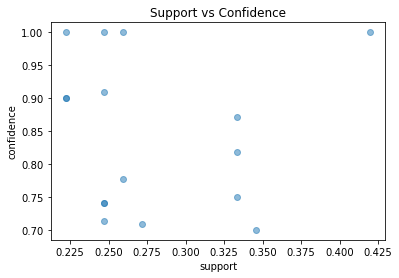

In [77]:
import matplotlib.pyplot as plt
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()